In [ ]:
# Data Source - https://drive.google.com/drive/folders/10SUoVOHnv95fLr-w2HSktjQUd96jXA3U?usp=sharing
# Data File - https://drive.google.com/file/d/1b3ZtbqWw0knl7yJKHrHYuflLpJewHfM6/view?usp=drive_link

### Project Objective
This notebook applies a **Decision Tree Classifier** to predict whether a bank customer will subscribe to a term deposit (target: `deposit`) using the **Bank Marketing dataset**. The workflow demonstrates how decision trees can be tuned to improve prediction accuracy and avoid underfitting or overfitting.  
The project highlights the practical use of hyperparameter tuning in machine learning for business-focused outcomes.  

#### Outline
- Step 1: Data loading from CSV (bank marketing data)  
- Step 2: Data preprocessing (Label Encoding of categorical features)  
- Step 3: Splitting dataset into training and testing sets  
- Step 4: Baseline Decision Tree model training and evaluation  
- Step 5: Testing different tree depths to analyze bias-variance tradeoff  
- Step 6: Hyperparameter tuning using GridSearchCV  
- Step 7: Final model evaluation with multiple metrics (Accuracy, Precision, Recall, F1, ROC-AUC)  
- Step 8: Business insights from model performance  

**Final takeaway:** Properly tuned Decision Trees can provide interpretable and accurate predictions for customer subscription likelihood, helping businesses target the right clients effectively.
~~~markdown


In [1]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Avoid harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Reading the data
data = pd.read_csv('/content/drive/MyDrive/Datasets/Input/bank.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


### Data Dictionary

1. **age**: Customer age (numeric)  
2. **job**: Type of job (categorical: *admin, unknown, unemployed, management, housemaid, entrepreneur, student, blue-collar, self-employed, retired, technician, services*)  
3. **marital**: Marital status (categorical: *married, divorced, single*; note: “divorced” includes widowed)  
4. **education**: Education level (categorical: *unknown, secondary, primary, tertiary*)  
5. **default**: Has credit in default? (binary: *yes, no*)  
6. **balance**: Average yearly balance in euros (numeric)  
7. **housing**: Has housing loan? (binary: *yes, no*)  
8. **loan**: Has personal loan? (binary: *yes, no*)  

**Last Contact Information (Current Campaign):**  
9. **contact**: Contact communication type (categorical: *unknown, telephone, cellular*)  
10. **day**: Last contact day of the month (numeric)  
11. **month**: Last contact month of year (categorical: *jan, feb, …, nov, dec*)  
12. **duration**: Last contact duration in seconds (numeric)  
13. **campaign**: Number of contacts during this campaign (numeric, includes last contact)  
14. **pdays**: Days since client was last contacted from a previous campaign (numeric; *-1 means never contacted*)  
15. **previous**: Number of contacts before this campaign (numeric)  
16. **poutcome**: Outcome of previous marketing campaign (categorical: *unknown, other, failure, success*)  

**Target Variable:**  
17. **deposit**: Has the client subscribed to a term deposit? (binary: *yes, no*)
~~~markdown


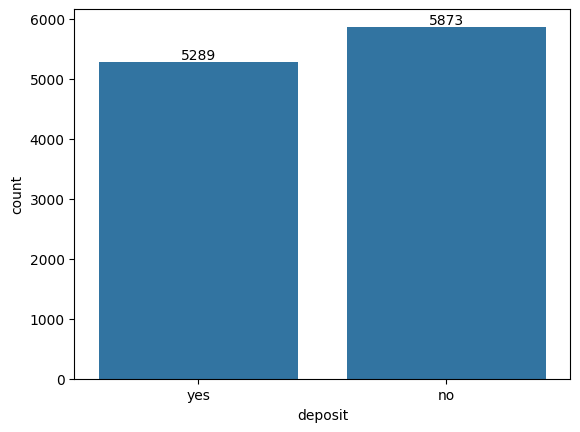

In [ ]:
# Analyse the target column

ax = sns.countplot(data, x='deposit')
ax.bar_label(ax.containers[0])
plt.show()

#### Explanation
This visualization analyzes the **target variable (`deposit`)** to understand class distribution.  
- The chart shows two categories: **"yes"** (customer subscribed) and **"no"** (customer did not subscribe).  
- Counts are roughly balanced, with about **5,289 "yes"** and **5,873 "no"** responses.  

Why this matters:  
- Balanced classes reduce the risk of biased model predictions.  
- It confirms that accuracy will be a reliable evaluation metric, since one class does not overwhelmingly dominate the other.  
This step is crucial for understanding the prediction goal before building Decision Tree models.
~~~markdown

In [ ]:
# Null value check
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [ ]:
# Data type of the columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [ ]:
# Check the unique values in categorical data

for cols in data.columns:
    if data[cols].dtype == 'O':
        print(cols,':',data[cols].nunique())

job : 12
marital : 3
education : 4
default : 2
housing : 2
loan : 2
contact : 3
month : 12
poutcome : 4
deposit : 2


In [ ]:
# Check the unique values in numerical data

for cols in data.columns:
    if data[cols].dtype != 'O':
        print(cols,':',data[cols].nunique())

age : 76
balance : 3805
day : 31
duration : 1428
campaign : 36
pdays : 472
previous : 34


##### This step explores the **unique values in categorical and numerical columns**:

- **Categorical Features**:  
  - `job` has 12 categories, `marital` has 3, `education` has 4, etc.  
  - The target column `deposit` has 2 values: *yes* and *no*.  

- **Numerical Features**:  
  - Ranges vary widely, e.g., `balance` has 3,805 unique values, `duration` has 1,428, and `pdays` has 472.  

Why this matters:  
- Helps identify how diverse each feature is.  
- Guides preprocessing decisions: categorical features will need encoding, while numerical features may require scaling or binning if their range is too broad.  
- Confirms that the dataset has a mix of categorical and numerical variables, making it a good fit for tree-based models like Decision Trees (since they handle both types well).
~~~markdown

In [ ]:
# data sample
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## Preparing data for ML Model

In [7]:
# mapping the month column
data['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

##### This code checks all unique values in the **`month` column**. It helps confirm that months are represented as text values (`'jan', 'feb', …, 'dec'`), which need to be converted into numerical format before training a machine learning model.  

In [8]:
# Mapping for month
maps = {'jan': 1, 'feb': 2, 'mar' : 3, 'apr': 4, 'may': 5, 'jun': 6,
        'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

# Apply the mapping
data['month'] = data['month'].map(maps)

##### Here, a dictionary (`maps`) is created to assign numerical values to month names (`'jan': 1`, `'feb': 2`, …, `'dec': 12`). Then, the mapping is applied to the `month` column. This transformation ensures that months are represented consistently as numbers, making them usable by the Decision Tree classifier.  

In [9]:
# label encoding the data
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

for cols in data:
    if data[cols].dtype == 'O':
        data[cols] = encoder.fit_transform(data[cols])

##### The code uses **LabelEncoder** to convert all categorical (object-type) columns into numerical values. For each categorical column, unique text values (like job roles, education levels, etc.) are replaced with integer codes. This is essential because machine learning algorithms can only work with numeric inputs.  

In [ ]:
# data sample
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,0,1,1,0,2343,1,0,2,5,5,1042,1,-1,0,3,1
1,56,0,1,1,0,45,0,0,2,5,5,1467,1,-1,0,3,1
2,41,9,1,1,0,1270,1,0,2,5,5,1389,1,-1,0,3,1
3,55,7,1,1,0,2476,1,0,2,5,5,579,1,-1,0,3,1
4,54,0,1,2,0,184,0,0,2,5,5,673,2,-1,0,3,1


##### This confirms that categorical variables and the `month` column are now encoded numerically, making the dataset fully ready for model training.  

In [10]:
# Data dependency split
x = data.drop('deposit', axis=1)
y = data['deposit']

# train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

##### The dataset is split into:  
- **X**: all independent variables (customer details, contact history, etc.).  
- **y**: the dependent variable (`deposit`), which is the prediction target.  
##### This separation ensures the model only uses features to predict the outcome.  
##### The data is split into **training (70%)** and **testing (30%)** sets using `train_test_split`.  
- Training data is used to build the model.  
- Testing data is kept unseen to evaluate performance.  
##### The `random_state=42` ensures reproducibility of results.  


In [11]:
# Shape of the data split
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(7813, 16)
(3349, 16)
(7813,)
(3349,)


##### The printed shapes confirm the split:  
- Training set: 7,813 rows, 16 features.  
- Test set: 3,349 rows, 16 features.  
##### Balanced splitting ensures enough data for both training and evaluation.  

In [55]:
# Decision tree algorithm
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42, max_depth=8, criterion='gini')
model.fit(x_train, y_train)
training_score = model.score(x_train, y_train)
print(round(training_score*100, 2), '%')

87.38 %


##### A **DecisionTreeClassifier** is created with:  
- `criterion='gini'`: Gini index for measuring impurity.  
- `max_depth=8`: limits tree growth to avoid overfitting.  
##### The model is trained on training data, achieving **87.38% training accuracy**. This acts as a baseline model before tuning.  

In [56]:
# prediction testing
y_pred = model.predict(x_test)

##### The trained Decision Tree model is used to predict the target variable (`deposit`) on the unseen **test dataset**. The predictions (`y_pred`) will be compared with the actual labels (`y_test`).  


Testing Accuracy: 82.0


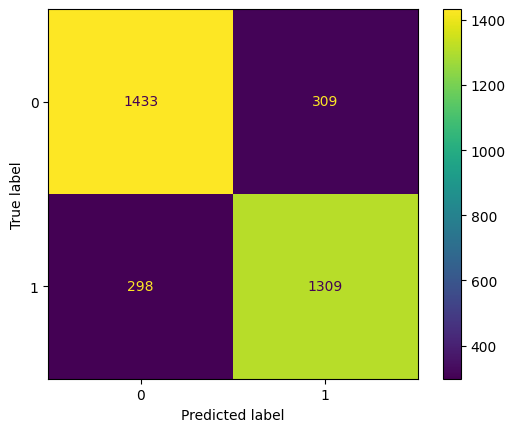

In [57]:
# Model metrics
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score

cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print('Testing Accuracy:', round(accuracy_score(y_test, y_pred),2)*100)

Here, evaluation metrics are applied:  
- A **confusion matrix** is displayed to show how well the model distinguishes between customers who subscribed (`yes`) and those who didn’t (`no`).  
- The test accuracy is **82%**, meaning the model correctly predicted the outcome for 82 out of every 100 customers.  

Why this matters:  
- The confusion matrix highlights both correct predictions (diagonal values) and misclassifications (off-diagonal values).  
- Accuracy gives a single performance number, but in later steps, additional metrics like precision, recall, and F1-score will provide a deeper understanding of business impact.
~~~markdown

## Manual Fine Tuning

In [25]:
# Decision tree algorithm

for num in [2,4,6,8,10,12,14,16,18,20]:
    model = DecisionTreeClassifier(random_state=42, max_depth=num, criterion='gini')
    model.fit(x_train, y_train)
    training_score = model.score(x_train, y_train)
    print(f'Model with max_depth {num}:', round(training_score, 2))

Model with max_depth 2: 0.72
Model with max_depth 4: 0.79
Model with max_depth 6: 0.83
Model with max_depth 8: 0.87
Model with max_depth 10: 0.91
Model with max_depth 12: 0.94
Model with max_depth 14: 0.97
Model with max_depth 16: 0.98
Model with max_depth 18: 0.99
Model with max_depth 20: 0.99


A loop is used to train Decision Tree models with different `max_depth` values (2, 4, 6, …, 20).  
- **Observation**:  
  - Shallow trees (e.g., depth=2) underfit with low training accuracy (~72%).  
  - Deeper trees (e.g., depth=18–20) almost perfectly fit training data (~99%), showing overfitting risk.  
  - Intermediate depth (around 12) balances complexity and accuracy.  

This experiment demonstrates the **bias-variance tradeoff** in Decision Trees.  

In [20]:
# Assuming max_depth 12 as best model
best_model = DecisionTreeClassifier(random_state=42, max_depth=12, criterion='gini')
best_model.fit(x_train, y_train)
training_score = best_model.score(x_train, y_train)
print(f'Training Score:', round(training_score, 2))

Training Score: 0.94


Based on the manual tuning results, `max_depth=12` is chosen as the best balance point.  
The selected model achieves a **94% training score**, which is high but not overly perfect, reducing the risk of overfitting.  

This step showcases the importance of **manual hyperparameter exploration** before moving on to automated tuning methods like GridSearchCV.
~~~markdown

Testing Accuracy: 80.0


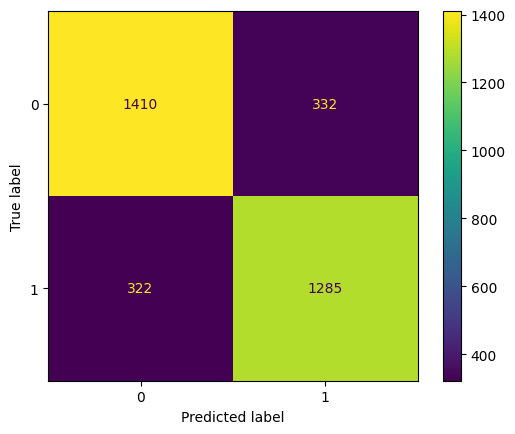

In [22]:
# prediction testing with assumed best model
y_pred = best_model.predict(x_test)

# Model metrics

cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print('Testing Accuracy:', round(accuracy_score(y_test, y_pred),2)*100)

The chosen Decision Tree model (`max_depth=12`) is evaluated on the **test set**.  
- The confusion matrix shows predictions vs actual outcomes:  
  - **1410 true negatives** (correctly predicted "no deposit").  
  - **1285 true positives** (correctly predicted "yes deposit").  
  - **332 false positives** and **322 false negatives** (misclassifications).  

- The overall **testing accuracy is 80%**, slightly lower than the baseline (82%).  

Why this matters:  
- The drop in accuracy shows that even though training accuracy was high, the model may still be slightly over

### Hyper parameter Tuning

In [26]:
from sklearn.model_selection import GridSearchCV

In [48]:
# Parameter grid for tuning
param_grid = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [None, 2, 4, 6, 8, 10],
              'min_samples_split': [2, 4, 6, 8],
              'min_samples_leaf': [1, 2, 4]}

A parameter grid is created with multiple options for Decision Tree hyperparameters:  
- **criterion**: split quality measure (*gini* or *entropy*).  
- **splitter**: strategy for splitting nodes (*best* or *random*).  
- **max_depth**: tree depth control (None or values 2–10).  
- **min_samples_split**: minimum samples required to split a node.  
- **min_samples_leaf**: minimum samples required at a leaf node.  

This ensures a broad search space for finding the most effective configuration.  

In [49]:
# Hyper parameter tuning

# Creating a classifer
dt = DecisionTreeClassifier()

# setup the grid search
grid_search = GridSearchCV(estimator=dt,
                           param_grid=param_grid,
                           cv = 5,
                           n_jobs = -1,
                           verbose = 3)

# fitting the model
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6, 8],
                         'splitter': ['best', 'random']},
             verbose=3)

- A base DecisionTreeClassifier is initialized.  
- **GridSearchCV** is used with:  
  - `cv=5`: 5-fold cross-validation for robust evaluation.  
  - `n_jobs=-1`: parallel computation for faster execution.  
  - `verbose=3`: progress logging during search.  

The grid search tests **288 parameter combinations across 5 folds (1,440 fits total)**.  

Why this matters:  
Automated hyperparameter tuning provides a systematic and unbiased way to optimize model performance, avoiding manual trial-and-error.
~~~markdown

In [58]:
# Displaying the best parameter and best score
print('Best Parameter:', grid_search.best_params_)
print('Best Score:', grid_search.best_score_)

Best Parameter: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 8, 'splitter': 'best'}
Best Score: 0.8218365155160592


GridSearchCV identifies the optimal hyperparameters:  
- **criterion**: `'entropy'`  
- **max_depth**: `8`  
- **min_samples_leaf**: `2`  
- **min_samples_split**: `4`  

The best cross-validation score achieved is **82.18%**, showing improved generalization compared to the manually tuned model.  

In [59]:
# Building our final model with best parameters
best_params = grid_search.best_params_
final_model = DecisionTreeClassifier(**best_params)

# Fitting the data onto the model
final_model.fit(x_train, y_train)

# Model Score
print('Training Score:', final_model.score(x_train, y_train))

Training Score: 0.8560092154102138


Using the best parameters, a new **DecisionTreeClassifier** is trained.  
- The training accuracy is **85.6%**, which is lower than deeper overfit models but more realistic for generalization.  

Why this matters:  
- This step confirms that automated hyperparameter tuning leads to a **better-balanced model**, reducing overfitting and improving the chance of strong test performance.
~~~markdow

In [65]:
# Evaluating the final model
y_pred = final_model.predict(x_test)

# Testing accuracy
print('Testing Accuracy:', accuracy_score(y_test, y_pred))
print('Recall Score:', recall_score(y_test, y_pred))
print('Precision Score:', precision_score(y_test, y_pred))
print('F1-Score:', f1_score(y_test, y_pred))

Testing Accuracy: 0.8217378321887131
Recall Score: 0.8014934660858744
Precision Score: 0.822477650063857
F1-Score: 0.8118499842420422


The final tuned Decision Tree is evaluated using multiple performance metrics:  

- **Testing Accuracy**: 82.17% → overall correctness of predictions.  
- **Recall**: 80.14% → ability to correctly identify customers who subscribed (`deposit=yes`).  
- **Precision**: 82.24% → reliability of positive predictions (how many predicted “yes” were actually correct).  
- **F1-Score**: 81.18% → harmonic mean of precision and recall, balancing both metrics.  

Why this matters:  
- Instead of relying on accuracy alone, these metrics give a **complete picture** of model performance.  
- In a business context, high recall ensures fewer missed opportunities (customers likely to subscribe), while good precision avoids wasting resources on unlikely customers.  
~~~markdown

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1742
           1       0.82      0.80      0.81      1607

    accuracy                           0.82      3349
   macro avg       0.82      0.82      0.82      3349
weighted avg       0.82      0.82      0.82      3349



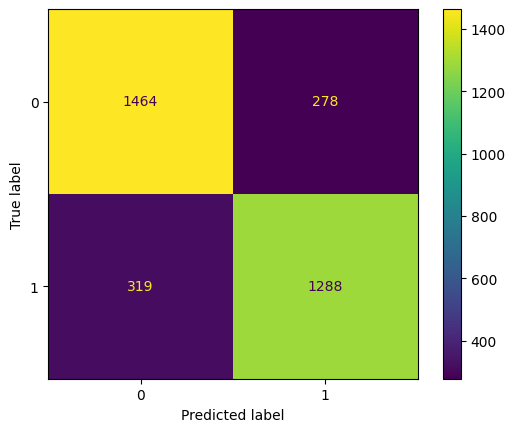

In [64]:
# Confusion Matrix
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)

The classification report and confusion matrix give a **detailed breakdown of model performance**:

- **Class 0 (No deposit)**:  
  - Precision: 0.82, Recall: 0.84, F1: 0.83  
  - The model is strong at correctly identifying customers who did not subscribe.  

- **Class 1 (Yes deposit)**:  
  - Precision: 0.82, Recall: 0.80, F1: 0.81  
  - The model also performs well for predicting subscribers, with only a small drop in recall.  

- **Overall Accuracy**: 82%  
- **Macro/Weighted Averages**: Both at 0.82, confirming balanced performance across both classes.  

The **confusion matrix** confirms this balance:  
- 1,464 true negatives and 1,288 true positives dominate.  
- Misclassifications (278 false positives, 319 false negatives) are relatively low.  

Why this matters:  
This step demonstrates that the tuned Decision Tree provides **consistent and reliable predictions** for both classes, making it useful in real business scenarios where both missed opportunities and false targeting are costly.
~~~markdown

In [81]:
# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
print('AUC Score:', auc_score)

AUC Score: 0.8209533920555663


The model’s performance is further validated using the **ROC-AUC score**:  

- **AUC Score: 0.82**  
  - This means the model has an 82% chance of correctly distinguishing between a customer who will subscribe and one who will not.  
  - A score above 0.80 indicates strong classification ability.  

Why this matters:  
Unlike accuracy, the AUC considers the trade-off between **true positive rate (recall)** and **false positive rate**, making it a more reliable metric when both classes are important in business decisions.
~~~markdown

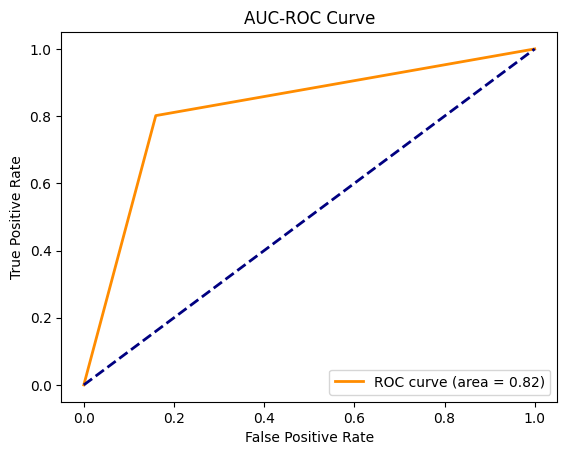

In [79]:
# Plot the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, ls='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()

The **ROC curve** is plotted to visualize the trade-off between:  
- **True Positive Rate (TPR / Recall)** on the Y-axis  
- **False Positive Rate (FPR)** on the X-axis  

Key points:  
- The orange ROC curve lies well above the diagonal baseline, confirming that the model performs significantly better than random guessing.  
- The **AUC value of 0.82** is displayed in the legend, reinforcing strong discriminative power.  

Why this matters:  
ROC curves provide a **visual confirmation** of the model’s ability to separate positive (deposit=yes) and negative (deposit=no) cases, making it a compelling addition for employers reviewing the project.
~~~markdown